### Work Directory's PATH Definition

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [3]:
data_path = "/content/drive/MyDrive/Nova Ims/Asset Pricing & Portfolio Management/Project/DataFrames/"
path = "/content/drive/MyDrive/Nova Ims/Asset Pricing & Portfolio Management/Project/"

### Importing Packages

In [4]:
!pip install ace_tools_open

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.3 MB/s eta 0:00:00


In [5]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import jarque_bera, norm, t, skew, kurtosis, linregress
from scipy.optimize import minimize
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.covariance import LedoitWolf
from scipy.stats import kendalltau
import ace_tools_open  as tools;

from statsmodels.stats.diagnostic import acorr_ljungbox
import os

### DataFrame Initialization

In [6]:
# Defining the portfolio tickers

tickers_dict = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Tesla': 'TSLA',
    'JPM': 'JPM',
    'Nasdaq': 'QQQ',
    'SP500': '^GSPC',
    'Gold': 'GC=F',
    'Oil': 'CL=F',
    'Bitcoin': 'BTC-USD',
    'Ethereum': 'ETH-USD'
}

In [7]:
#Daily Log Returns Dataset

daily_log_returns = pd.read_csv("/content/drive/MyDrive/Nova Ims/Asset Pricing & Portfolio Management/Project/DataFrames/daily_log_returns.csv", index_col = 0)

daily_log_returns = daily_log_returns.dropna()

daily_log_returns

,AAPL,BTC-USD,CL=F,ETH-USD,GC=F,JPM,MSFT,QQQ,TSLA,^GSPC
2017-11-10 00:00:00+00:00,-0.003315,-0.076400,-0.007550,-0.069790,-0.010321,-0.001230,-0.002619,-0.000065,0.000000,-0.000898
2017-11-14 00:00:00+00:00,-0.015233,0.011559,-0.018852,0.063948,0.003283,-0.006047,0.001429,-0.003646,-0.021472,-0.002312
2017-11-15 00:00:00+00:00,-0.013278,0.097529,-0.006665,-0.012740,-0.003909,0.009414,-0.007803,-0.004708,0.008387,-0.005541
2017-11-16 00:00:00+00:00,0.011876,0.073272,-0.003440,-0.007325,0.000705,0.002848,0.002648,0.012698,0.003847,0.008163
2017-11-17 00:00:00+00:00,-0.005568,-0.020886,0.025250,0.004432,0.014302,-0.003357,-0.009662,-0.003825,0.008127,-0.002629
...,...,...,...,...,...,...,...,...,...,...
2024-09-19 00:00:00+00:00,0.036395,0.020721,0.014560,0.039316,0.006707,0.014115,0.018126,0.024970,0.071010,0.016834
2024-09-20 00:00:00+00:00,-0.002932,0.004004,-0.000417,0.038335,0.012251,0.002894,-0.007827,-0.001905,-0.023520,-0.001943
2024-09-24 00:00:00+00:00,0.003966,0.015234,0.016769,0.002191,0.009360,0.000709,-0.010062,0.004812,0.016936,0.002508
2024-09-25 00:00:00+00:00,-0.004408,-0.018186,-0.026479,-0.028649,0.003013,-0.006639,0.006827,0.000927,0.010757,-0.001863


In [8]:
train_end_date = "2022-09-26"
test_start_date = "2022-09-27"

# Training data: From 10/11/2017 to 26/09/2022
train_data = daily_log_returns[:train_end_date]

# Testing data: From 27/09/2022 to 26/09/2024
test_data = daily_log_returns[test_start_date:]

### Equally Weight Portfolio (Index)

In [9]:
Set up equal weights for all assets
num_assets = train_data.shape[1]  # Number of assets in the dataset
equal_weights = np.ones(num_assets) / num_assets  # Equal weight for each asset

Calculate portfolio returns on the test data using equal weights
portfolio_returns_eqw_test = np.dot(test_data.values, equal_weights)

Calculate performance metrics for the Equally Weighted Portfolio
# Average daily return and daily volatility
average_daily_return_eqw_test = np.mean(portfolio_returns_eqw_test)
daily_volatility_eqw_test = np.std(portfolio_returns_eqw_test)

# Annualize metrics
trading_days_per_year = 252
annualized_return_eqw_test = (1 + average_daily_return_eqw_test) ** trading_days_per_year - 1
annualized_volatility_eqw_test = daily_volatility_eqw_test * np.sqrt(trading_days_per_year)

# Sharpe Ratio (assuming a risk-free rate of 0)
risk_free_rate = 0  # Adjust if needed
sharpe_ratio_eqw_test = (annualized_return_eqw_test - risk_free_rate) / annualized_volatility_eqw_test

# Calculate drawdown
cumulative_returns_eqw_test = np.cumprod(1 + portfolio_returns_eqw_test)
peak_eqw_test = np.maximum.accumulate(cumulative_returns_eqw_test)
drawdown_eqw_test = (cumulative_returns_eqw_test - peak_eqw_test) / peak_eqw_test
max_drawdown_eqw_test = np.min(drawdown_eqw_test)

# Step 4: Print the metrics for the Equally Weighted Portfolio
print("Portfolio Equal Weights:", equal_weights)
print("Annualized Return (Equally Weighted Portfolio):", round(annualized_return_eqw_test, 2))
print("Annualized Volatility (Equally Weighted Portfolio):", round(annualized_volatility_eqw_test, 2))
print("Sharpe Ratio (Equally Weighted Portfolio):", round(sharpe_ratio_eqw_test, 2))
print("Maximum Drawdown (Equally Weighted Portfolio):", round(max_drawdown_eqw_test, 2))

Portfolio Equal Weights: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Annualized Return (Equally Weighted Portfolio): 0.24
Annualized Volatility (Equally Weighted Portfolio): 0.2
Sharpe Ratio (Equally Weighted Portfolio): 1.24
Maximum Drawdown (Equally Weighted Portfolio): -0.13


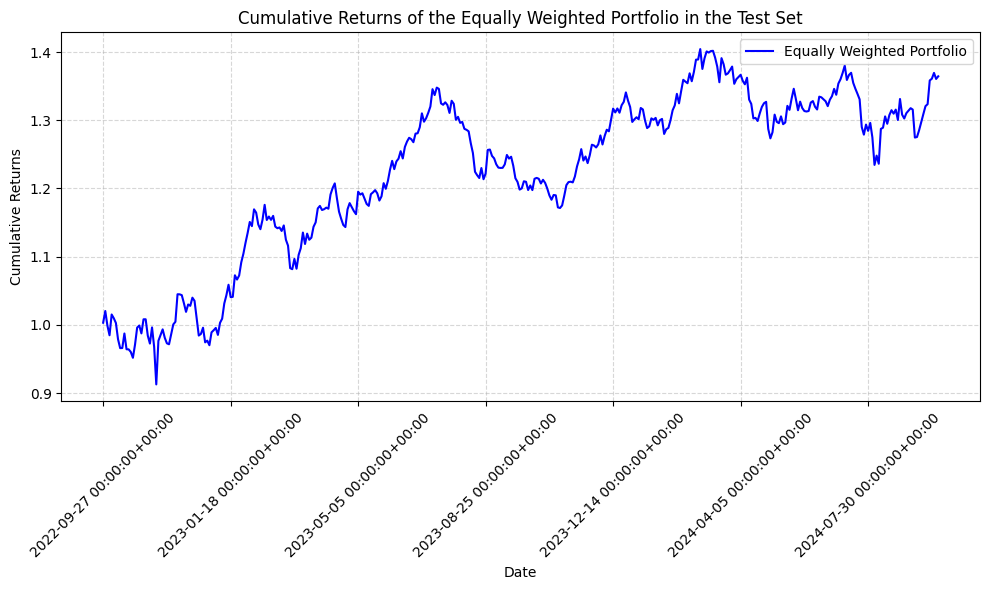

In [10]:
# Create a plot for the cumulative returns of the Equally Weighted Portfolio in the test set
plt.figure(figsize=(10, 6))

plt.plot(test_data.index, cumulative_returns_eqw_test, label="Equally Weighted Portfolio", color="blue")
plt.xticks(test_data.index[::60], rotation=45)
plt.title("Cumulative Returns of the Equally Weighted Portfolio in the Test Set")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### Mean-downside (Semivariance ) risk portfolio



```
Implementing the Mean-Downside (Semivariance) Risk Portfolio involves a strategy that minimizes the downside risk instead of the total variance of a portfolio's returns. Here’s the step-by-step explanation logic and how we can implement it in Python:

Explanation Logic:
1. Definition of Downside Risk:

Instead of considering the variance (both upside and downside) as in traditional mean-variance optimization, we focus only on the downside part of the returns. Specifically, semivariance measures the risk of returns falling below a target or the mean.
2. Steps to Implement:

 * Step 1: Calculate Semivariance
  * Define a target return (commonly 0 or the mean return).
  * Calculate the semivariance for each asset, which is the average of the squared deviations of negative returns from the target return.
 * Step 2: Formulate the Optimization Problem
  * We aim to minimize the downside risk subject to the constraints that the sum of the portfolio weights equals 1 and that weights are non-negative (if we assume no short-selling).
 * Step 3: Use an Optimization Solver
  * Use an optimization library like scipy.optimize to find the weights that minimize the semivariance.
```



In [11]:
# Define a function to calculate downside risk (Semivariance)
def semivariance(returns, target_return=0):
    downside_deviation = returns[returns < target_return] - target_return
    return np.mean(downside_deviation ** 2)

# Define a function to calculate the portfolio semivariance
def portfolio_semivariance(weights, returns, target_return=0):
    portfolio_return = np.dot(returns, weights)
    return semivariance(portfolio_return, target_return)

# Define the optimization constraints and bounds
num_assets = train_data.shape[1]
initial_weights = np.ones(num_assets) / num_assets  # Start with equal weights
bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]  # Sum of weights equals 1

#Optimize the portfolio using the training data
result = minimize(portfolio_semivariance, initial_weights,
                  args=(train_data.values,),
                  bounds=bounds, constraints=constraints)

optimal_weights = result.x
print("Optimized Portfolio Weights (Mean-Downside Risk):", optimal_weights)

# Evaluate the portfolio on the test data
# Portfolio returns on the test data
portfolio_returns_mds_test = np.dot(test_data.values, optimal_weights)
average_daily_return_mds_test = np.mean(portfolio_returns_mds_test)
daily_volatility_mds_test = np.std(portfolio_returns_mds_test)

# Annualize metrics
trading_days_per_year = 252
annualized_return_mds_test = (1 + average_daily_return_mds_test) ** trading_days_per_year - 1
annualized_volatility_mds_test = daily_volatility_mds_test * np.sqrt(trading_days_per_year)

# Assuming a risk-free rate of 0
risk_free_rate = 0
sharpe_ratio_mds_test = (annualized_return_mds_test - risk_free_rate) / annualized_volatility_mds_test

# Calculate drawdown
cumulative_returns_mds_test = np.cumprod(1 + portfolio_returns_mds_test)
peak_mds_test = np.maximum.accumulate(cumulative_returns_mds_test)
drawdown_mds_test = (cumulative_returns_mds_test - peak_mds_test) / peak_mds_test
max_drawdown_mds_test = np.min(drawdown_mds_test)

# Print the metrics
print("Annualized Return (Test Data):", round(annualized_return_mds_test, 2))
print("Annualized Volatility (Test Data):", round(annualized_volatility_mds_test, 2))
print("Sharpe Ratio (Test Data):", round(sharpe_ratio_mds_test, 2))
print("Maximum Drawdown (Test Data):", round(max_drawdown_mds_test, 2))

Optimized Portfolio Weights (Mean-Downside Risk): [0.11265673 0.04048352 0.12682702 0.         0.15577867 0.12474777
 0.1168547  0.1181732  0.079569   0.12490939]
Annualized Return (Test Data): 0.25
Annualized Volatility (Test Data): 0.16
Sharpe Ratio (Test Data): 1.55
Maximum Drawdown (Test Data): -0.13


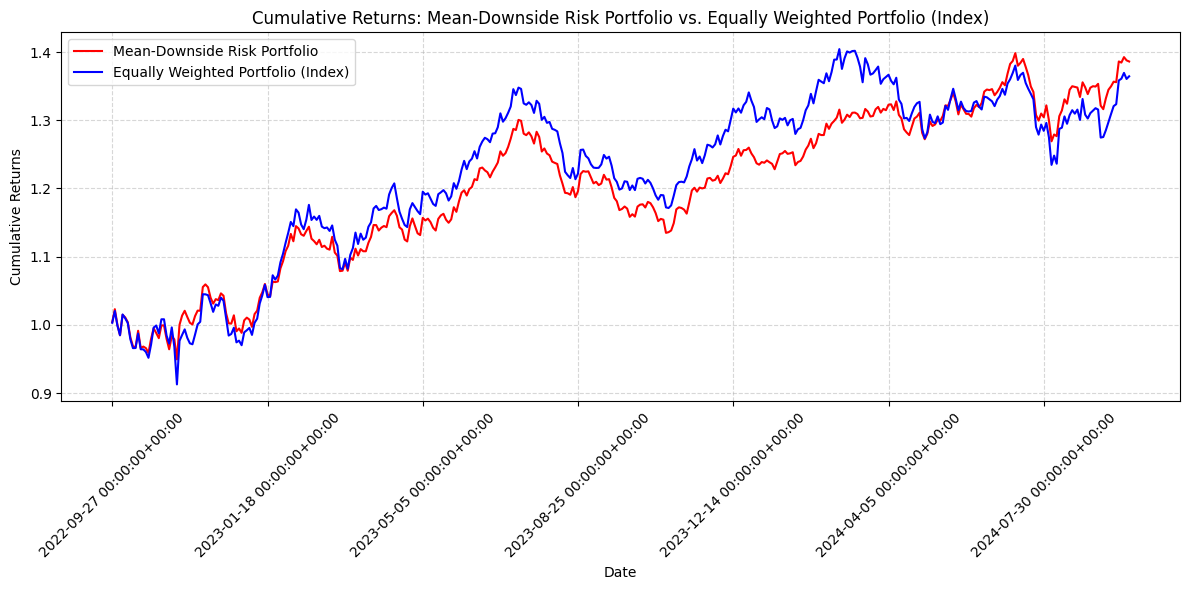

In [12]:
plt.figure(figsize=(12, 6))

# Plot the Mean-Downside Risk Portfolio cumulative returns
plt.plot(test_data.index, cumulative_returns_mds_test, label="Mean-Downside Risk Portfolio", color="red")

# Plot the Equally Weighted Portfolio (Index) cumulative returns
plt.plot(test_data.index, cumulative_returns_eqw_test, label="Equally Weighted Portfolio (Index)", color="blue")
plt.xticks(test_data.index[::60], rotation=45)
# Customize the plot
plt.title("Cumulative Returns: Mean-Downside Risk Portfolio vs. Equally Weighted Portfolio (Index)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
# Convert the optimized portfolio weights for the Black-Litterman Model to percentages and round to 2 decimal places
optimal_weights_percent = (optimal_weights * 100).round(1)

# Create a DataFrame to display the weights clearly
weights_df = pd.DataFrame({
    "Asset": train_data.columns,
    "Weight (%)": optimal_weights_percent
})

weights_df.set_index("Asset", inplace=True)

# Display the table with the weights
weights_df

,Weight (%)
Asset,
AAPL,11.3
BTC-USD,4.0
CL=F,12.7
ETH-USD,0.0
GC=F,15.6
JPM,12.5
MSFT,11.7
QQQ,11.8
TSLA,8.0


### Hierarchical Risk Parity Portfolio



```
Let's move on to the Hierarchical Risk Parity (HRP) Portfolio. This approach aims to allocate weights based on hierarchical clustering, minimizing risk concentration without relying on traditional covariance matrix inversion.

Hierarchical Risk Parity (HRP) Portfolio Logic:
1. Calculate the Correlation Matrix: Identify the relationships between different assets.
2. Compute a Distance Matrix: This matrix is derived from the correlation matrix to understand how "far apart" assets are from each other.
3. Hierarchical Clustering: Use a clustering algorithm to create a hierarchical tree (dendrogram) of assets.
4. Assign Weights Using Recursive Bisection: Allocate weights based on the hierarchical tree structure, balancing risk evenly across the clusters.
```



In [14]:
#Calculate the correlation matrix and convert it to a distance matrix
correlation_matrix = train_data.corr()
distance_matrix = np.sqrt(2 * (1 - correlation_matrix))

#Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='single')

#Get the clusters using a dendrogram cut-off
clusters = fcluster(linkage_matrix, t=0.5, criterion='distance')

Allocate weights using the recursive bisection method
def get_cluster_variance(returns, cluster_indices):
    cluster_returns = returns[:, cluster_indices]
    cov_matrix = np.cov(cluster_returns, rowvar=False)
    return np.sum(np.diag(cov_matrix))

def recursive_bisection(returns, clusters):
    unique_clusters = np.unique(clusters)
    weights = np.zeros(len(clusters))
    cluster_indices = {i: np.where(clusters == i)[0] for i in unique_clusters}

    # Start with equal weights for each cluster
    cluster_weights = np.ones(len(unique_clusters)) / len(unique_clusters)

    # Allocate weights to each asset within the clusters
    for i, cluster in enumerate(unique_clusters):
        indices = cluster_indices[cluster]
        n_assets_in_cluster = len(indices)
        weights[indices] = cluster_weights[i] / n_assets_in_cluster

    return weights

# Get the asset returns as a numpy array
returns_array = train_data.values
weights_hrp = recursive_bisection(returns_array, clusters)
print("Optimized Portfolio Weights (Hierarchical Risk Parity):", weights_hrp)

Calculate Portfolio Metrics
# Portfolio returns
portfolio_returns_hrp_test = np.dot(test_data.values, weights_hrp)
average_daily_return_hrp_test = np.mean(portfolio_returns_hrp_test)
daily_volatility_hrp_test = np.std(portfolio_returns_hrp_test)

# Calculate the number of trading days in the test period
num_trading_days_test = len(test_data)

# Annualize metrics
annualized_return_hrp_test = (1 + average_daily_return_hrp_test) ** trading_days_per_year - 1
annualized_volatility_hrp_test = daily_volatility_hrp_test * np.sqrt(trading_days_per_year)

# Assume a risk-free rate of 0 (you can adjust this if needed)
risk_free_rate = 0
sharpe_ratio_hrp_test = (annualized_return_hrp_test - risk_free_rate) / annualized_volatility_hrp_test

# Calculate drawdown
cumulative_returns_hrp_test = np.cumprod(1 + portfolio_returns_hrp_test)
peak_hrp_test = np.maximum.accumulate(cumulative_returns_hrp_test)
drawdown_hrp_test = (cumulative_returns_hrp_test - peak_hrp_test) / peak_hrp_test
max_drawdown_hrp_test = np.min(drawdown_hrp_test)

Print the metrics
print("Annualized Return (Test Data):", round(annualized_return_hrp_test, 2))
print("Annualized Volatility (Test Data):", round(annualized_volatility_hrp_test, 2))
print("Sharpe Ratio (Test Data):", round(sharpe_ratio_hrp_test, 2))
print("Maximum Drawdown (Test Data):", round(max_drawdown_hrp_test, 2))

Optimized Portfolio Weights (Hierarchical Risk Parity): [0.125      0.125      0.125      0.125      0.125      0.125
 0.04166667 0.04166667 0.125      0.04166667]
Annualized Return (Test Data): 0.22
Annualized Volatility (Test Data): 0.21
Sharpe Ratio (Test Data): 1.08
Maximum Drawdown (Test Data): -0.14


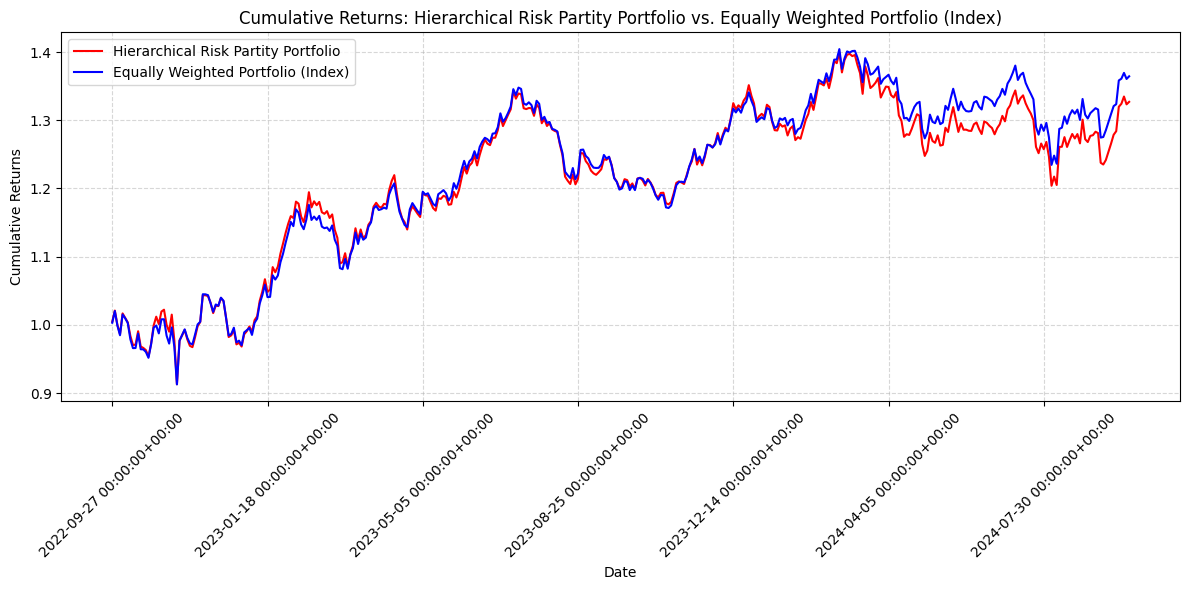

In [15]:
plt.figure(figsize=(12, 6))

# Plot the Mean-Downside Risk Portfolio cumulative returns
plt.plot(test_data.index, cumulative_returns_hrp_test, label="Hierarchical Risk Partity Portfolio", color="red")

# Plot the Equally Weighted Portfolio (Index) cumulative returns
plt.plot(test_data.index, cumulative_returns_eqw_test, label="Equally Weighted Portfolio (Index)", color="blue")
plt.xticks(test_data.index[::60], rotation=45)
# Customize the plot
plt.title("Cumulative Returns: Hierarchical Risk Partity Portfolio vs. Equally Weighted Portfolio (Index)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
# Convert the optimized portfolio weights for the Black-Litterman Model to percentages and round to 2 decimal places
weights_hrp_percent = (weights_hrp * 100).round(1)

# Create a DataFrame to display the weights clearly
weights_df = pd.DataFrame({
    "Asset": train_data.columns,
    "Weight (%)": weights_hrp_percent
})

weights_df.set_index("Asset", inplace=True)

# Display the table with the weights
weights_df

,Weight (%)
Asset,
AAPL,12.5
BTC-USD,12.5
CL=F,12.5
ETH-USD,12.5
GC=F,12.5
JPM,12.5
MSFT,4.2
QQQ,4.2
TSLA,12.5


### Mean-CVaR (Conditional Value At Risk or expected shortfall) portfolio



```
Let's implement the Mean-CVaR (Conditional Value at Risk or Expected Shortfall) Portfolio. This approach focuses on minimizing the risk of extreme losses, measured by CVaR. CVaR is the average of the worst-case losses beyond a specified percentile, providing a more comprehensive measure of tail risk compared to VaR (Value at Risk).

Implementation Logic:
1. Calculate CVaR: We define CVaR as the average loss beyond a specified Value at Risk (VaR) level.
2. Formulate the Optimization Problem:
  * The objective is to minimize the CVaR of the portfolio while considering a target return.
  * We use optimization libraries to find the portfolio weights that minimize CVaR.
3. Use the Same Performance Metrics: We’ll calculate annualized return, volatility, Sharpe ratio, and maximum drawdown.
```



In [17]:
# Define the CVaR calculation function
def calculate_cvar(returns, alpha=0.05):
    # Calculate the Value at Risk (VaR) at the given alpha level
    var = np.percentile(returns, alpha * 100)
    # Calculate the Conditional Value at Risk (CVaR)
    cvar = np.mean(returns[returns <= var])
    return -cvar  # Return the negative CVaR since we want to minimize losses

# Define a function to calculate the portfolio CVaR
def portfolio_cvar(weights, returns, alpha=0.05):
    portfolio_returns = np.dot(returns, weights)
    return calculate_cvar(portfolio_returns, alpha)

Set up the optimization problem
num_assets = train_data.shape[1]
initial_weights = np.ones(num_assets) / num_assets  # Start with equal weights
bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]  # Sum of weights equals 1

# Optimize the portfolio to minimize CVaR
result = minimize(portfolio_cvar, initial_weights,
                  args=(daily_log_returns.values,),
                  bounds=bounds, constraints=constraints)

# Extract the optimized weights
optimal_weights_cvar = result.x
print("Optimized Portfolio Weights (Mean-CVaR):", optimal_weights_cvar)

# Evaluate the portfolio on the test data
# Portfolio returns on the test data
portfolio_returns_cvar_test = np.dot(test_data.values, optimal_weights_cvar)
average_daily_return_cvar_test = np.mean(portfolio_returns_cvar_test)
daily_volatility_cvar_test = np.std(portfolio_returns_cvar_test)

# Annualize metrics
trading_days_per_year = 252
annualized_return_cvar_test = (1 + average_daily_return_cvar_test) ** trading_days_per_year - 1
annualized_volatility_cvar_test = daily_volatility_cvar_test * np.sqrt(trading_days_per_year)

# Assuming a risk-free rate of 0
risk_free_rate = 0
sharpe_ratio_cvar_test = (annualized_return_cvar_test - risk_free_rate) / annualized_volatility_cvar_test

# Calculate drawdown
cumulative_returns_cvar_test = np.cumprod(1 + portfolio_returns_cvar_test)
peak_cvar_test = np.maximum.accumulate(cumulative_returns_cvar_test)
drawdown_cvar_test = (cumulative_returns_cvar_test - peak_cvar_test) / peak_cvar_test
max_drawdown_cvar_test = np.min(drawdown_cvar_test)

# Print the metrics
print("Annualized Return (Test Data):", round(annualized_return_cvar_test, 2))
print("Annualized Volatility (Test Data):", round(annualized_volatility_cvar_test, 2))
print("Sharpe Ratio (Test Data):", round(sharpe_ratio_cvar_test, 2))
print("Maximum Drawdown (Test Data):", round(max_drawdown_cvar_test, 2))

Optimized Portfolio Weights (Mean-CVaR): [3.16455009e-17 0.00000000e+00 1.44972873e-02 1.17285679e-17
 6.74501843e-01 7.09157935e-02 2.46388300e-17 3.71931053e-18
 1.12643146e-17 2.40085076e-01]
Annualized Return (Test Data): 0.33
Annualized Volatility (Test Data): 0.12
Sharpe Ratio (Test Data): 2.83
Maximum Drawdown (Test Data): -0.08


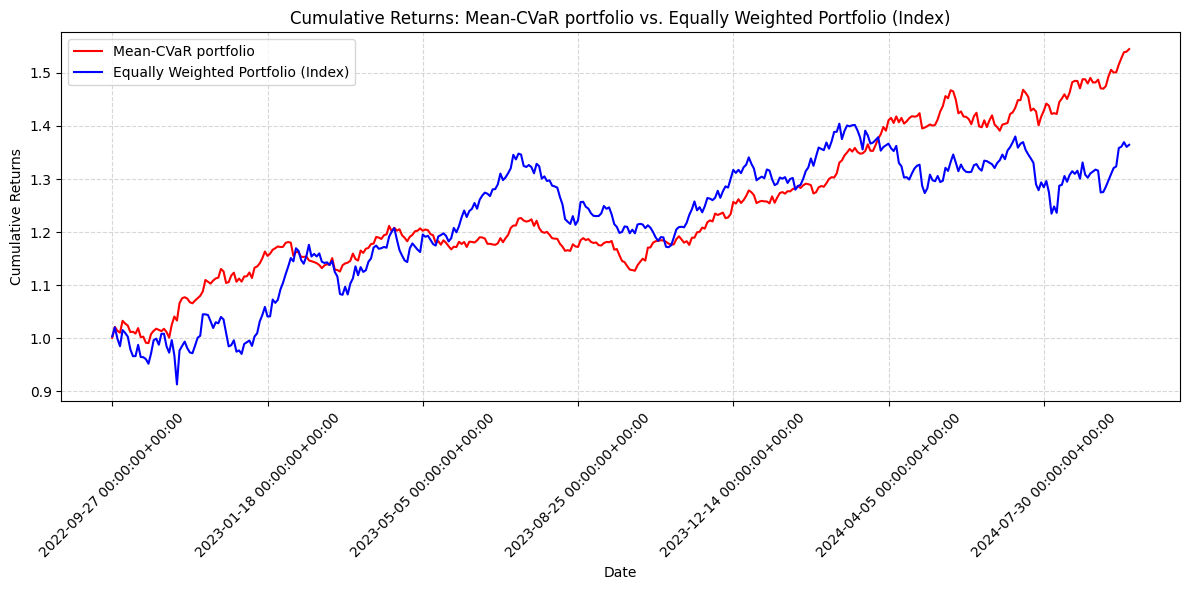

In [18]:
plt.figure(figsize=(12, 6))

# Plot the Mean-Downside Risk Portfolio cumulative returns
plt.plot(test_data.index, cumulative_returns_cvar_test, label="Mean-CVaR portfolio", color="red")

# Plot the Equally Weighted Portfolio (Index) cumulative returns
plt.plot(test_data.index, cumulative_returns_eqw_test, label="Equally Weighted Portfolio (Index)", color="blue")
plt.xticks(test_data.index[::60], rotation=45)
# Customize the plot
plt.title("Cumulative Returns: Mean-CVaR portfolio vs. Equally Weighted Portfolio (Index)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
# Convert the optimized portfolio weights for the Black-Litterman Model to percentages and round to 2 decimal places
optimal_weights_cvar_percent = (optimal_weights_cvar * 100).round(1)

# Create a DataFrame to display the weights clearly
weights_df = pd.DataFrame({
    "Asset": train_data.columns,
    "Weight (%)": optimal_weights_cvar_percent
})

weights_df.set_index("Asset", inplace=True)

# Display the table with the weights
weights_df

,Weight (%)
Asset,
AAPL,0.0
BTC-USD,0.0
CL=F,1.4
ETH-USD,0.0
GC=F,67.5
JPM,7.1
MSFT,0.0
QQQ,0.0
TSLA,0.0


### Minimum CDar (Conditional Drawdown At Risk) portfolio



```
Let's proceed to implement the Minimum CDaR (Conditional Drawdown at Risk) Portfolio. CDaR focuses on minimizing the expected drawdown beyond a specified threshold. It is a risk measure that considers the worst-case losses in terms of drawdowns rather than simple returns, making it a useful tool for risk-averse investors.

Implementation Logic:
1. Calculate CDaR: CDaR is the average of the worst-case drawdowns beyond a certain threshold (similar to CVaR but applied to drawdowns).
2. Formulate the Optimization Problem:
  * The objective is to minimize the Conditional Drawdown at Risk of the portfolio.
  * We use optimization techniques to find the weights that minimize CDaR.
3. Use the Same Performance Metrics: We’ll calculate annualized return, volatility, Sharpe ratio, and maximum drawdown.
```



In [20]:
# Define a function to calculate drawdown
def calculate_drawdown(returns):
    cumulative_returns = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown

# Step 2: Define a function to calculate Conditional Drawdown at Risk (CDaR)
def calculate_cdar(returns, alpha=0.05):
    drawdown = calculate_drawdown(returns)
    var_drawdown = np.percentile(drawdown, (1 - alpha) * 100)
    cdar = np.mean(drawdown[drawdown <= var_drawdown])
    return -cdar  # Return the negative CDaR to minimize drawdown

# Define a function to calculate the portfolio CDaR
def portfolio_cdar(weights, returns, alpha=0.05):
    portfolio_returns = np.dot(returns, weights)
    return calculate_cdar(portfolio_returns, alpha)

# Set up the optimization problem
num_assets = train_data.shape[1]
initial_weights = np.ones(num_assets) / num_assets  # Start with equal weights
bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]  # Sum of weights equals 1

# Optimize the portfolio to minimize CDaR using the training data
result = minimize(portfolio_cdar, initial_weights,
                  args=(train_data.values,),
                  bounds=bounds, constraints=constraints)

# Extract the optimized weights
optimal_weights_cdar = result.x
print("Optimized Portfolio Weights (Minimum CDaR):", optimal_weights_cdar)

# Evaluate the portfolio on the test data
# Portfolio returns on the test data
portfolio_returns_cdar_test = np.dot(test_data.values, optimal_weights_cdar)
average_daily_return_cdar_test = np.mean(portfolio_returns_cdar_test)
daily_volatility_cdar_test = np.std(portfolio_returns_cdar_test)

# Annualize metrics
trading_days_per_year = 252
annualized_return_cdar_test = (1 + average_daily_return_cdar_test) ** trading_days_per_year - 1
annualized_volatility_cdar_test = daily_volatility_cdar_test * np.sqrt(trading_days_per_year)

# Assuming a risk-free rate of 0
risk_free_rate = 0
sharpe_ratio_cdar_test = (annualized_return_cdar_test - risk_free_rate) / annualized_volatility_cdar_test

# Calculate drawdown
cumulative_returns_cdar_test = np.cumprod(1 + portfolio_returns_cdar_test)
peak_cdar_test = np.maximum.accumulate(cumulative_returns_cdar_test)
drawdown_cdar_test = (cumulative_returns_cdar_test - peak_cdar_test) / peak_cdar_test
max_drawdown_cdar_test = np.min(drawdown_cdar_test)

# Print the metrics
print("Annualized Return (Test Data):", round(annualized_return_cdar_test, 2))
print("Annualized Volatility (Test Data):", round(annualized_volatility_cdar_test, 2))
print("Sharpe Ratio (Test Data):", round(sharpe_ratio_cdar_test, 2))
print("Maximum Drawdown (Test Data):", round(max_drawdown_cdar_test, 2))

Optimized Portfolio Weights (Minimum CDaR): [1.35599086e-17 0.00000000e+00 9.15688863e-02 0.00000000e+00
 4.76186975e-01 0.00000000e+00 2.45046009e-01 0.00000000e+00
 0.00000000e+00 1.87198129e-01]
Annualized Return (Test Data): 0.31
Annualized Volatility (Test Data): 0.13
Sharpe Ratio (Test Data): 2.4
Maximum Drawdown (Test Data): -0.09


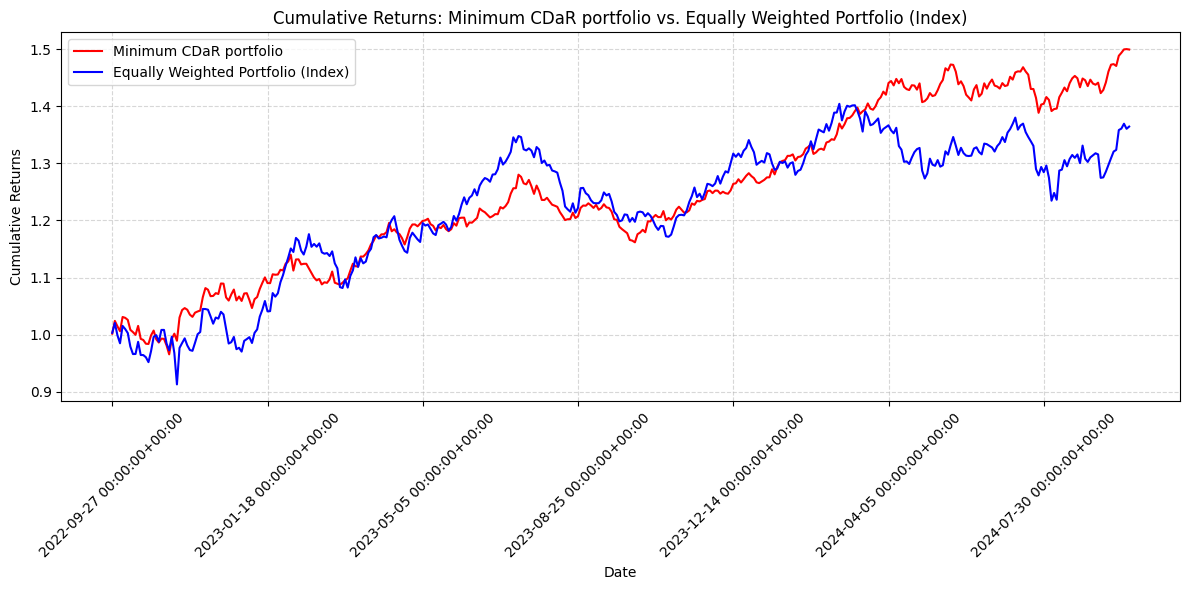

In [21]:
plt.figure(figsize=(12, 6))

# Plot the Mean-Downside Risk Portfolio cumulative returns
plt.plot(test_data.index, cumulative_returns_cdar_test, label="Minimum CDaR portfolio", color="red")

# Plot the Equally Weighted Portfolio (Index) cumulative returns
plt.plot(test_data.index, cumulative_returns_eqw_test, label="Equally Weighted Portfolio (Index)", color="blue")
plt.xticks(test_data.index[::60], rotation=45)
# Customize the plot
plt.title("Cumulative Returns: Minimum CDaR portfolio vs. Equally Weighted Portfolio (Index)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
# Convert the optimized portfolio weights for the Black-Litterman Model to percentages and round to 2 decimal places
optimal_weights_cdar_percent = (optimal_weights_cdar * 100).round(1)

# Create a DataFrame to display the weights clearly
weights_df = pd.DataFrame({
    "Asset": train_data.columns,
    "Weight (%)": optimal_weights_cdar_percent
})

weights_df.set_index("Asset", inplace=True)

# Display the table with the weights
weights_df

,Weight (%)
Asset,
AAPL,0.0
BTC-USD,0.0
CL=F,9.2
ETH-USD,0.0
GC=F,47.6
JPM,0.0
MSFT,24.5
QQQ,0.0
TSLA,0.0


### Mean Absolute Deviation portfolio (MAD)



```
Let's proceed with the Mean Absolute Deviation (MAD) Portfolio. The Mean Absolute Deviation Portfolio aims to minimize the average absolute deviation of portfolio returns from the mean return, which is a robust measure of risk compared to traditional variance-based measures.

Implementation Logic:
1. Calculate Mean Absolute Deviation (MAD): This is the average of the absolute differences between each return and the mean return of the portfolio.
2. Formulate the Optimization Problem:
  * The goal is to minimize the MAD of the portfolio while ensuring the sum of the portfolio weights equals 1.
  * We use an optimization solver to determine the optimal weights.
3. Use the Same Performance Metrics: We’ll calculate annualized return, volatility, Sharpe ratio, and maximum drawdown.
```



In [23]:
# Define a function to calculate Mean Absolute Deviation (MAD)
def mean_absolute_deviation(returns):
    mean_return = np.mean(returns)
    mad = np.mean(np.abs(returns - mean_return))
    return mad

# Define a function to calculate the portfolio MAD
def portfolio_mad(weights, returns):
    portfolio_returns = np.dot(returns, weights)
    return mean_absolute_deviation(portfolio_returns)

# Set up the optimization problem
num_assets = train_data.shape[1]
initial_weights = np.ones(num_assets) / num_assets  # Start with equal weights
bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]  # Sum of weights equals 1

# Optimize the portfolio to minimize MAD using the training data
result = minimize(portfolio_mad, initial_weights,
                  args=(train_data.values,),
                  bounds=bounds, constraints=constraints)

# Extract the optimized weights
optimal_weights_mad = result.x
print("Optimized Portfolio Weights (Mean Absolute Deviation):", optimal_weights_mad)

# Evaluate the portfolio on the test data
# Portfolio returns on the test data
portfolio_returns_mad_test = np.dot(test_data.values, optimal_weights_mad)
average_daily_return_mad_test = np.mean(portfolio_returns_mad_test)
daily_volatility_mad_test = np.std(portfolio_returns_mad_test)

# Annualize metrics
trading_days_per_year = 252
annualized_return_mad_test = (1 + average_daily_return_mad_test) ** trading_days_per_year - 1
annualized_volatility_mad_test = daily_volatility_mad_test * np.sqrt(trading_days_per_year)

# Assuming a risk-free rate of 0
risk_free_rate = 0
sharpe_ratio_mad_test = (annualized_return_mad_test - risk_free_rate) / annualized_volatility_mad_test

# Calculate drawdown
cumulative_returns_mad_test = np.cumprod(1 + portfolio_returns_mad_test)
peak_mad_test = np.maximum.accumulate(cumulative_returns_mad_test)
drawdown_mad_test = (cumulative_returns_mad_test - peak_mad_test) / peak_mad_test
max_drawdown_mad_test = np.min(drawdown_mad_test)

# Print the metrics
print("Annualized Return (Test Data):", round(annualized_return_mad_test, 2))
print("Annualized Volatility (Test Data):", round(annualized_volatility_mad_test, 2))
print("Sharpe Ratio (Test Data):", round(sharpe_ratio_mad_test, 2))
print("Maximum Drawdown (Test Data):", round(max_drawdown_mad_test, 2))

Optimized Portfolio Weights (Mean Absolute Deviation): [2.46855478e-18 0.00000000e+00 3.14118263e-03 1.45861263e-18
 6.40715246e-01 5.17394277e-02 0.00000000e+00 0.00000000e+00
 7.38111129e-18 3.04404143e-01]
Annualized Return (Test Data): 0.33
Annualized Volatility (Test Data): 0.12
Sharpe Ratio (Test Data): 2.82
Maximum Drawdown (Test Data): -0.08


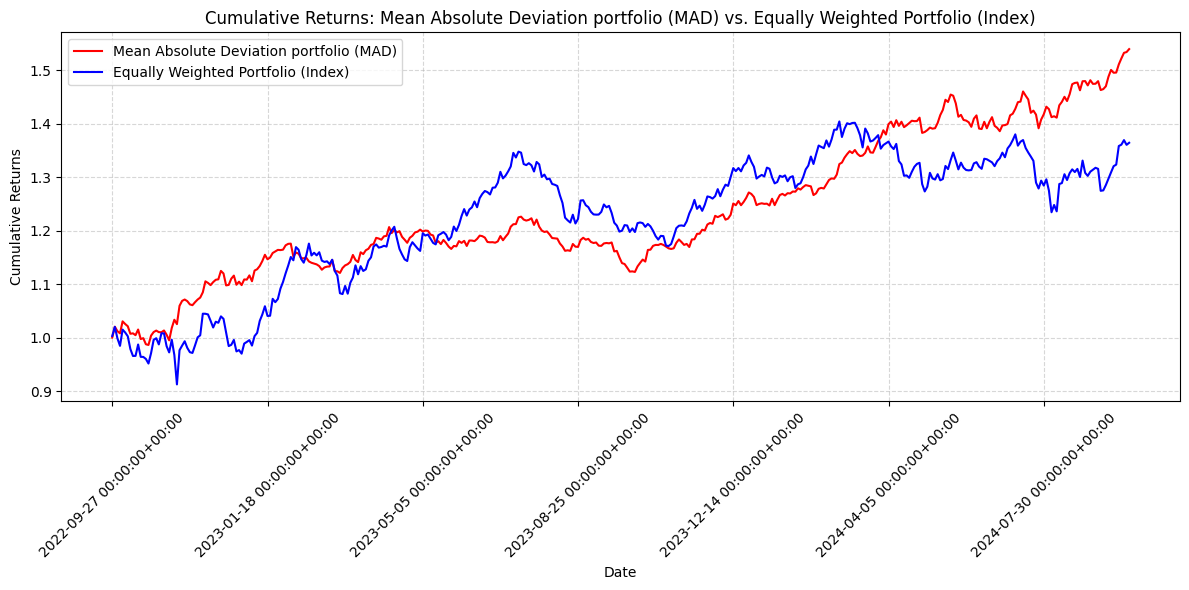

In [24]:
plt.figure(figsize=(12, 6))

# Plot the Mean-Downside Risk Portfolio cumulative returns
plt.plot(test_data.index, cumulative_returns_mad_test, label="Mean Absolute Deviation portfolio (MAD)", color="red")

# Plot the Equally Weighted Portfolio (Index) cumulative returns
plt.plot(test_data.index, cumulative_returns_eqw_test, label="Equally Weighted Portfolio (Index)", color="blue")
plt.xticks(test_data.index[::60], rotation=45)
# Customize the plot
plt.title("Cumulative Returns: Mean Absolute Deviation portfolio (MAD) vs. Equally Weighted Portfolio (Index)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
# Convert the optimized portfolio weights for the Black-Litterman Model to percentages and round to 2 decimal places
optimal_weights_mad_percent = (optimal_weights_mad * 100).round(1)

# Create a DataFrame to display the weights clearly
weights_df = pd.DataFrame({
    "Asset": train_data.columns,
    "Weight (%)": optimal_weights_mad_percent
})

weights_df.set_index("Asset", inplace=True)

# Display the table with the weights
weights_df

,Weight (%)
Asset,
AAPL,0.0
BTC-USD,0.0
CL=F,0.3
ETH-USD,0.0
GC=F,64.1
JPM,5.2
MSFT,0.0
QQQ,0.0
TSLA,0.0


### Maximum Omega Ratio (MOR)



```
The Maximum Omega Ratio (MOR) Portfolio aims to maximize the Omega Ratio, which is a performance measure comparing the likelihood of achieving returns greater than a certain threshold (typically a minimum acceptable return) to the likelihood of returns falling below that threshold.
```



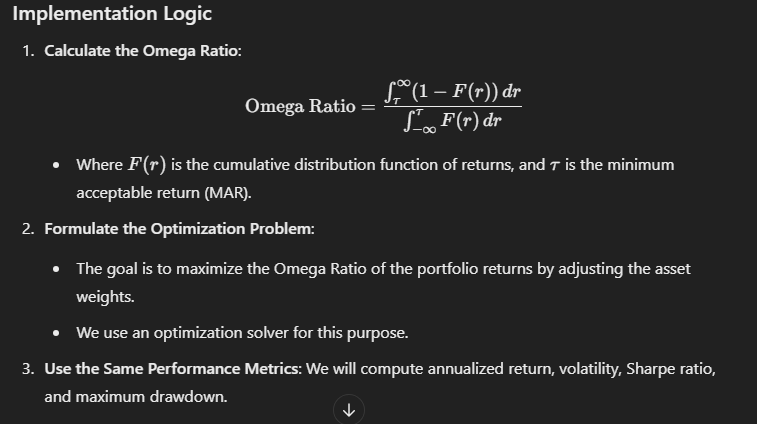

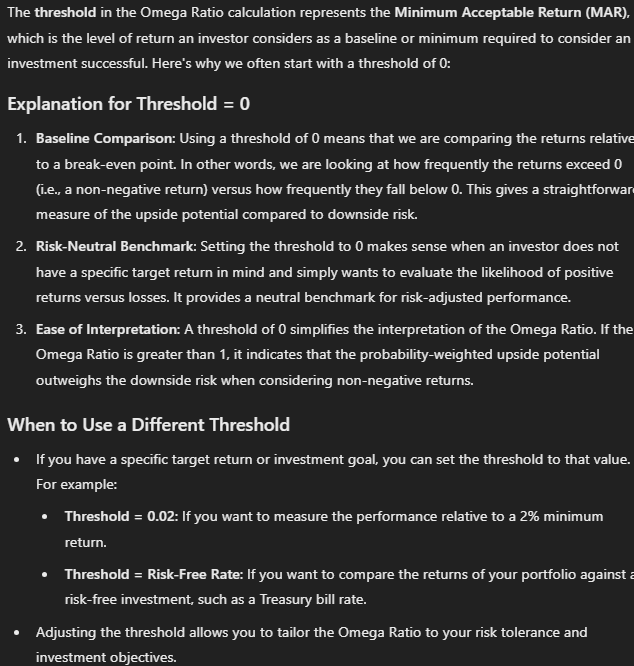

In [26]:
# Define the Omega Ratio calculation function
def omega_ratio(returns, threshold=0):
    excess_returns = returns - threshold
    positive_sum = np.sum(excess_returns[excess_returns > 0])
    negative_sum = -np.sum(excess_returns[excess_returns < 0])
    if negative_sum == 0:  # Avoid division by zero
        return np.inf
    return positive_sum / negative_sum

# Define a function to calculate the portfolio Omega Ratio
def portfolio_omega_ratio(weights, returns, threshold=0):
    portfolio_returns = np.dot(returns, weights)
    return -omega_ratio(portfolio_returns, threshold)  # We negate it because we want to maximize

# Set up the optimization problem
num_assets = train_data.shape[1]
initial_weights = np.ones(num_assets) / num_assets  # Start with equal weights
bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]  # Sum of weights equals 1

# Optimize the portfolio to maximize the Omega Ratio using the training data
result = minimize(portfolio_omega_ratio, initial_weights,
                  args=(train_data.values,),
                  bounds=bounds, constraints=constraints)

# Extract the optimized weights
optimal_weights_mor = result.x
print("Optimized Portfolio Weights (Maximum Omega Ratio):", optimal_weights_mor)

# Evaluate the portfolio on the test data
# Portfolio returns on the test data
portfolio_returns_mor_test = np.dot(test_data.values, optimal_weights_mor)
average_daily_return_mor_test = np.mean(portfolio_returns_mor_test)
daily_volatility_mor_test = np.std(portfolio_returns_mor_test)

# Annualize metrics
trading_days_per_year = 252
annualized_return_mor_test = (1 + average_daily_return_mor_test) ** trading_days_per_year - 1
annualized_volatility_mor_test = daily_volatility_mor_test * np.sqrt(trading_days_per_year)

# Assuming a risk-free rate of 0
risk_free_rate = 0
sharpe_ratio_mor_test = (annualized_return_mor_test - risk_free_rate) / annualized_volatility_mor_test

# Calculate drawdown
cumulative_returns_mor_test = np.cumprod(1 + portfolio_returns_mor_test)
peak_mor_test = np.maximum.accumulate(cumulative_returns_mor_test)
drawdown_mor_test = (cumulative_returns_mor_test - peak_mor_test) / peak_mor_test
max_drawdown_mor_test = np.min(drawdown_mor_test)

# Print the metrics
print("Annualized Return (Test Data):", round(annualized_return_mor_test, 2))
print("Annualized Volatility (Test Data):", round(annualized_volatility_mor_test, 2))
print("Sharpe Ratio (Test Data):", round(sharpe_ratio_mor_test, 2))
print("Maximum Drawdown (Test Data):", round(max_drawdown_mor_test, 2))

Optimized Portfolio Weights (Maximum Omega Ratio): [3.17772123e-17 1.24272733e-16 2.71150832e-01 1.07763547e-17
 2.43436068e-01 6.03277729e-17 4.85413100e-01 2.20900925e-18
 7.47043529e-17 3.43964258e-18]
Annualized Return (Test Data): 0.26
Annualized Volatility (Test Data): 0.17
Sharpe Ratio (Test Data): 1.52
Maximum Drawdown (Test Data): -0.09


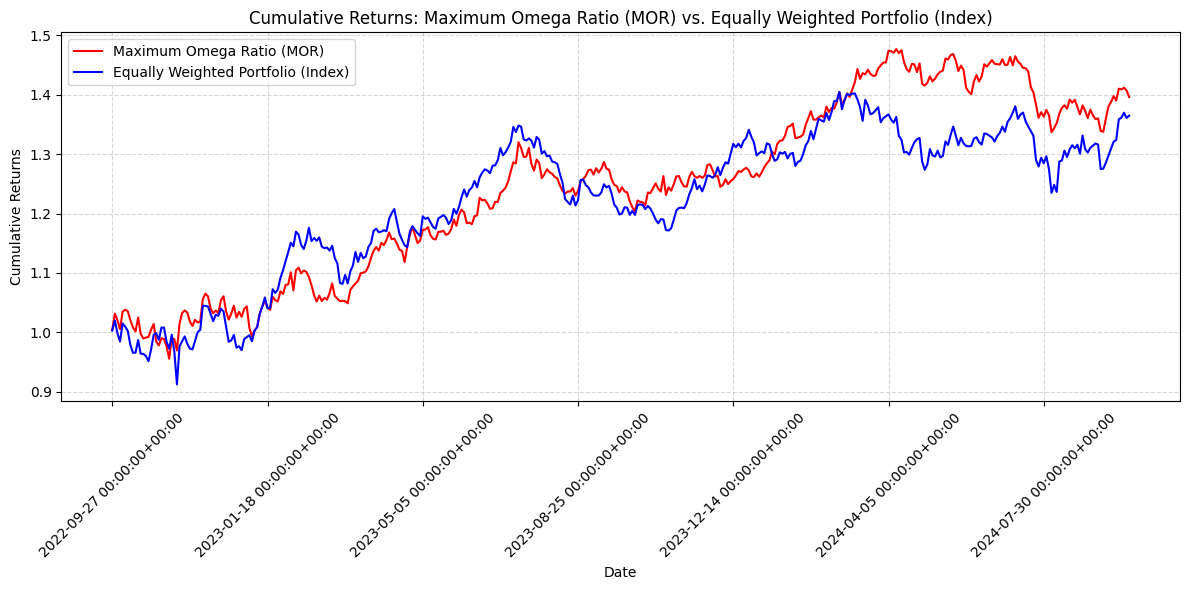

In [27]:
plt.figure(figsize=(12, 6))

# Plot the Mean-Downside Risk Portfolio cumulative returns
plt.plot(test_data.index, cumulative_returns_mor_test, label="Maximum Omega Ratio (MOR)", color="red")

# Plot the Equally Weighted Portfolio (Index) cumulative returns
plt.plot(test_data.index, cumulative_returns_eqw_test, label="Equally Weighted Portfolio (Index)", color="blue")
plt.xticks(test_data.index[::60], rotation=45)
# Customize the plot
plt.title("Cumulative Returns: Maximum Omega Ratio (MOR) vs. Equally Weighted Portfolio (Index)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
# Convert the optimized portfolio weights for the Black-Litterman Model to percentages and round to 2 decimal places
optimal_weights_mor_percent = (optimal_weights_mor * 100).round(1)

# Create a DataFrame to display the weights clearly
weights_df = pd.DataFrame({
    "Asset": train_data.columns,
    "Weight (%)": optimal_weights_mor_percent
})

weights_df.set_index("Asset", inplace=True)

# Display the table with the weights
weights_df

,Weight (%)
Asset,
AAPL,0.0
BTC-USD,0.0
CL=F,27.1
ETH-USD,0.0
GC=F,24.3
JPM,0.0
MSFT,48.5
QQQ,0.0
TSLA,0.0


### Tactical Dual Momentum strategy



```
The Tactical Dual Momentum Strategy is a rules-based investment approach that leverages the concept of momentum in both absolute and relative terms. Here’s how it works:

1. Absolute Momentum: Compares the performance of an asset to a risk-free rate (like Treasury bills) over a specified lookback period. If the asset's return exceeds the risk-free rate, it indicates positive momentum.
2. Relative Momentum: Compares the performance of multiple assets to each other over the same lookback period, selecting the asset(s) with the best performance.
3. Implementation Logic:
  * We will calculate the past returns over a specified lookback period.
  * Use absolute momentum to determine whether to be in the market or in cash.
  * Use relative momentum to decide which asset(s) to hold.
4. Performance Metrics: We will use annualized return, volatility, Sharpe ratio, and maximum drawdown.
```



In [29]:
# Parameters for the Tactical Dual Momentum Strategy
lookback_period = 252  # 1-year lookback period for momentum calculation
risk_free_rate = 0  # Adjust this if you have a different risk-free rate

# Calculate past returns over the lookback period
def calculate_momentum(returns, lookback_period):
    past_returns = (1 + returns).rolling(window=lookback_period).apply(np.prod, raw=True) - 1
    return past_returns

# Calculate the momentum for each asset
momentum_scores = calculate_momentum(daily_log_returns, lookback_period)

# Implement the Tactical Dual Momentum rules
def tactical_dual_momentum(returns, momentum_scores, risk_free_rate):
    # Identify the asset with the best relative momentum
    latest_momentum = momentum_scores.iloc[-1]
    best_asset_index = latest_momentum.idxmax()

    # Check the absolute momentum of the best asset
    if latest_momentum[best_asset_index] > risk_free_rate:
        # Invest in the asset with the best momentum
        weights = np.zeros(returns.shape[1])
        weights[daily_log_returns.columns.get_loc(best_asset_index)] = 1
    else:
        # Stay in cash (all weights are zero)
        weights = np.zeros(returns.shape[1])

    return weights

# Get the optimal weights using the strategy
optimal_weights_tdm = tactical_dual_momentum(train_data, momentum_scores, risk_free_rate)
print("Optimized Portfolio Weights (Tactical Dual Momentum):", optimal_weights_tdm)

# Evaluate the portfolio on the test data
# Portfolio returns on the test data
portfolio_returns_tdm_test = np.dot(test_data.values, optimal_weights_tdm)
average_daily_return_tdm_test = np.mean(portfolio_returns_tdm_test)
daily_volatility_tdm_test = np.std(portfolio_returns_tdm_test)

# Annualize metrics
trading_days_per_year = 252
annualized_return_tdm_test = (1 + average_daily_return_tdm_test) ** trading_days_per_year - 1
annualized_volatility_tdm_test = daily_volatility_tdm_test * np.sqrt(trading_days_per_year)

# Sharpe Ratio
sharpe_ratio_tdm_test = (annualized_return_tdm_test - risk_free_rate) / annualized_volatility_tdm_test

# Calculate drawdown
cumulative_returns_tdm_test = np.cumprod(1 + portfolio_returns_tdm_test)
peak_tdm_test = np.maximum.accumulate(cumulative_returns_tdm_test)
drawdown_tdm_test = (cumulative_returns_tdm_test - peak_tdm_test) / peak_tdm_test
max_drawdown_tdm_test = np.min(drawdown_tdm_test)

# Print the metrics
print("Annualized Return (Test Data):", round(annualized_return_tdm_test, 2))
print("Annualized Volatility (Test Data):", round(annualized_volatility_tdm_test, 2))
print("Sharpe Ratio (Test Data):", round(sharpe_ratio_tdm_test, 2))
print("Maximum Drawdown (Test Data):", round(max_drawdown_tdm_test, 2))

Optimized Portfolio Weights (Tactical Dual Momentum): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Annualized Return (Test Data): 0.36
Annualized Volatility (Test Data): 0.14
Sharpe Ratio (Test Data): 2.52
Maximum Drawdown (Test Data): -0.1


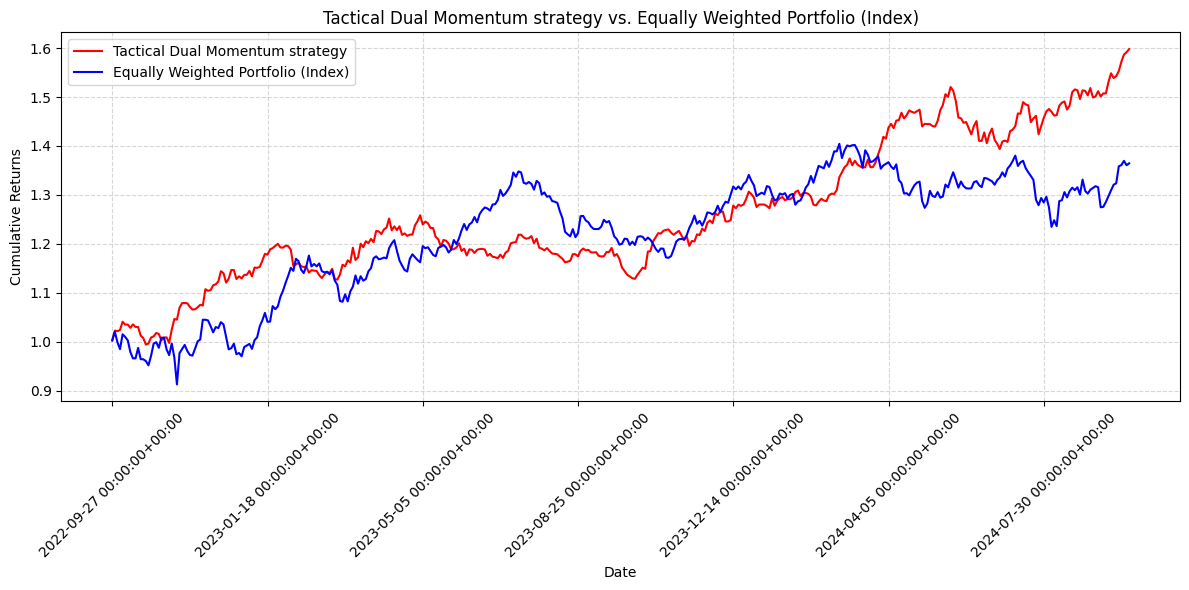

In [30]:
plt.figure(figsize=(12, 6))

# Plot the Mean-Downside Risk Portfolio cumulative returns
plt.plot(test_data.index, cumulative_returns_tdm_test, label="Tactical Dual Momentum strategy", color="red")

# Plot the Equally Weighted Portfolio (Index) cumulative returns
plt.plot(test_data.index, cumulative_returns_eqw_test, label="Equally Weighted Portfolio (Index)", color="blue")
plt.xticks(test_data.index[::60], rotation=45)
# Customize the plot
plt.title("Tactical Dual Momentum strategy vs. Equally Weighted Portfolio (Index)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [31]:
# Convert the optimized portfolio weights for the Black-Litterman Model to percentages and round to 2 decimal places
optimal_weights_tdm_percent = (optimal_weights_tdm * 100).round(1)

# Create a DataFrame to display the weights clearly
weights_df = pd.DataFrame({
    "Asset": train_data.columns,
    "Weight (%)": optimal_weights_tdm_percent
})

weights_df.set_index("Asset", inplace=True)

# Display the table with the weights
weights_df

,Weight (%)
Asset,
AAPL,0.0
BTC-USD,0.0
CL=F,0.0
ETH-USD,0.0
GC=F,100.0
JPM,0.0
MSFT,0.0
QQQ,0.0
TSLA,0.0


### Adaptive Asset Allocation strategy



```
Now, let's implement the Adaptive Asset Allocation (AAA) Strategy, which is a dynamic approach to portfolio construction that adjusts asset weights based on changing market conditions. The strategy typically involves selecting assets with strong recent momentum while considering risk metrics to maintain a balanced and adaptive portfolio.

Implementation Logic:
1. Calculate Recent Momentum: Use a lookback period to evaluate the momentum of each asset.
2. Estimate Risk (Volatility or Covariance): Assess the risk associated with each asset, often using the historical volatility or the covariance matrix.
3. Determine Asset Weights: Allocate more weight to assets with higher momentum and lower risk. This can be done using an optimization approach that maximizes a risk-adjusted measure, such as the Sharpe ratio.
```



In [32]:
# Parameters for the Adaptive Asset Allocation Strategy
lookback_period = 252  # 1-year lookback period for momentum and risk estimation
trading_days_per_year = 252
risk_free_rate = 0  # Adjust if needed

# Calculate past returns (momentum) and volatility (risk) over the lookback period
def calculate_momentum_and_risk(returns, lookback_period):
    momentum = (1 + returns).rolling(window=lookback_period).apply(np.prod, raw=True) - 1
    volatility = returns.rolling(window=lookback_period).std() * np.sqrt(trading_days_per_year)
    return momentum, volatility

momentum_scores, volatility_estimates = calculate_momentum_and_risk(daily_log_returns, lookback_period)

# Use the latest available momentum and volatility estimates
latest_momentum = momentum_scores.iloc[-1]
latest_volatility = volatility_estimates.iloc[-1]

# Define the objective function to maximize risk-adjusted return (e.g., Sharpe ratio)
def objective_function(weights, returns, volatility, risk_free_rate):
    # Calculate portfolio return and volatility
    portfolio_return = np.dot(returns, weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(np.cov(returns.T), weights)))

    # Calculate Sharpe ratio
    sharpe_ratio = (np.mean(portfolio_return) - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Negate because we want to maximize Sharpe ratio

# Set up the optimization problem
num_assets = train_data.shape[1]
initial_weights = np.ones(num_assets) / num_assets  # Start with equal weights
bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]  # Sum of weights equals 1

# Optimize the portfolio to maximize the Sharpe ratio using the training data
result = minimize(objective_function, initial_weights,
                  args=(train_data.values[-lookback_period:], latest_volatility, risk_free_rate),
                  bounds=bounds, constraints=constraints)

# Extract the optimized weights
optimal_weights_aaa = result.x
print("Optimized Portfolio Weights (Adaptive Asset Allocation):", optimal_weights_aaa)

# Evaluate the portfolio on the test data
# Portfolio returns on the test data
portfolio_returns_aaa_test = np.dot(test_data.values, optimal_weights_aaa)
average_daily_return_aaa_test = np.mean(portfolio_returns_aaa_test)
daily_volatility_aaa_test = np.std(portfolio_returns_aaa_test)

# Annualize metrics
annualized_return_aaa_test = (1 + average_daily_return_aaa_test) ** trading_days_per_year - 1
annualized_volatility_aaa_test = daily_volatility_aaa_test * np.sqrt(trading_days_per_year)

# Sharpe Ratio
sharpe_ratio_aaa_test = (annualized_return_aaa_test - risk_free_rate) / annualized_volatility_aaa_test

# Calculate drawdown
cumulative_returns_aaa_test = np.cumprod(1 + portfolio_returns_aaa_test)
peak_aaa_test = np.maximum.accumulate(cumulative_returns_aaa_test)
drawdown_aaa_test = (cumulative_returns_aaa_test - peak_aaa_test) / peak_aaa_test
max_drawdown_aaa_test = np.min(drawdown_aaa_test)

# Print the metrics
print("Annualized Return (Test Data):", round(annualized_return_aaa_test, 2))
print("Annualized Volatility (Test Data):", round(annualized_volatility_aaa_test, 2))
print("Sharpe Ratio (Test Data):", round(sharpe_ratio_aaa_test, 2))
print("Maximum Drawdown (Test Data):", round(max_drawdown_aaa_test, 2))

Optimized Portfolio Weights (Adaptive Asset Allocation): [4.61608605e-01 2.15973073e-16 3.40543601e-01 0.00000000e+00
 1.97847795e-01 0.00000000e+00 0.00000000e+00 9.54097912e-18
 0.00000000e+00 0.00000000e+00]
Annualized Return (Test Data): 0.21
Annualized Volatility (Test Data): 0.17
Sharpe Ratio (Test Data): 1.26
Maximum Drawdown (Test Data): -0.08


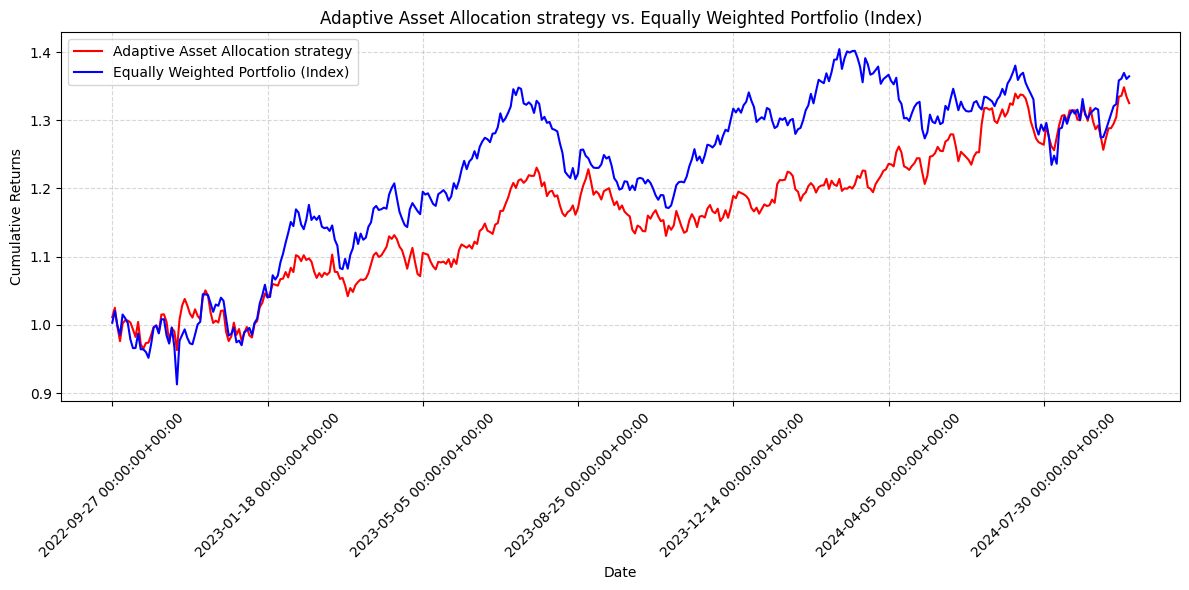

In [33]:
plt.figure(figsize=(12, 6))

# Plot the Mean-Downside Risk Portfolio cumulative returns
plt.plot(test_data.index, cumulative_returns_aaa_test, label="Adaptive Asset Allocation strategy", color="red")

# Plot the Equally Weighted Portfolio (Index) cumulative returns
plt.plot(test_data.index, cumulative_returns_eqw_test, label="Equally Weighted Portfolio (Index)", color="blue")
plt.xticks(test_data.index[::60], rotation=45)
# Customize the plot
plt.title("Adaptive Asset Allocation strategy vs. Equally Weighted Portfolio (Index)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [34]:
# Convert the optimized portfolio weights for the Black-Litterman Model to percentages and round to 2 decimal places
optimal_weights_aaa_percent = (optimal_weights_aaa * 100).round(1)

# Create a DataFrame to display the weights clearly
weights_df = pd.DataFrame({
    "Asset": train_data.columns,
    "Weight (%)": optimal_weights_aaa_percent
})

weights_df.set_index("Asset", inplace=True)

# Display the table with the weights
weights_df

,Weight (%)
Asset,
AAPL,46.2
BTC-USD,0.0
CL=F,34.1
ETH-USD,0.0
GC=F,19.8
JPM,0.0
MSFT,0.0
QQQ,0.0
TSLA,0.0


### Black-Litterman Model Portfolio


```
The Black-Litterman Model is a sophisticated portfolio construction method that combines the market equilibrium (capital market equilibrium assumptions) with investor views to derive a more customized set of optimal asset weights. Here’s how we can implement it, incorporating your specified views.

Key Steps in the Black-Litterman Model:
1. Define Market Equilibrium: Use the market capitalization weights of the assets to represent the market’s neutral view.
2. Incorporate Investor Views: Adjust the expected returns based on your views about the relative performance of assets.
3. Combine Views with Market Equilibrium: Use the Black-Litterman formula to derive a new set of expected returns that reflect both the market and your views.
4. Optimize the Portfolio: Use these adjusted returns to optimize the portfolio.


Asset 9 will outperform Asset 1 by 4%.
Asset 4 will outperform Asset 2 by 8%.
Asset 1 will outperform Asset 5 by 2%.

```




In [35]:
# Calculate the mean and covariance matrix of the returns using the training data
mean_returns = train_data.mean() * 252  # Annualized returns
cov_matrix = train_data.cov() * 252  # Annualized covariance matrix

# Assume market weights (you can adjust this if you have actual market cap data)
num_assets = train_data.shape[1]
market_weights = np.ones(num_assets) / num_assets

# Calculate the implied equilibrium returns using the risk aversion coefficient
risk_aversion = 3  # This can be adjusted based on your risk preference
implied_equilibrium_returns = risk_aversion * np.dot(cov_matrix, market_weights)

# Incorporate investor views
views = np.array([0.04, 0.08, 0.02])  # Investor views
P = np.zeros((3, num_assets))
P[0, [8, 0]] = [1, -1]  # Asset 9 - Asset 1 = 4%
P[1, [3, 1]] = [1, -1]  # Asset 4 - Asset 2 = 8%
P[2, [0, 4]] = [1, -1]  # Asset 1 - Asset 5 = 2%

# Uncertainty in the views (Omega matrix)
omega = np.diag([0.04**2, 0.08**2, 0.02**2])  # Variance of views

# Calculate the adjusted expected returns using the Black-Litterman formula
tau = 0.025  # Scalar for the uncertainty in the prior (can be adjusted)
M = np.linalg.inv(np.linalg.inv(tau * cov_matrix) + np.dot(P.T, np.linalg.inv(omega).dot(P)))
adjusted_returns = np.dot(M, (np.dot(np.linalg.inv(tau * cov_matrix), implied_equilibrium_returns) + np.dot(P.T, np.linalg.inv(omega).dot(views))))

# Define the objective function to maximize risk-adjusted return (e.g., Sharpe ratio)
def objective_function(weights, returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Negate because we want to maximize Sharpe ratio

# Set up the optimization problem
initial_weights = np.ones(num_assets) / num_assets  # Start with equal weights
bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]  # Sum of weights equals 1

# Optimize the portfolio using the adjusted returns
result = minimize(objective_function, initial_weights,
                  args=(adjusted_returns, cov_matrix, 0),
                  bounds=bounds, constraints=constraints)

# Extract the optimized weights
optimal_weights_bl = result.x
print("Optimized Portfolio Weights (Black-Litterman):", optimal_weights_bl)

# Evaluate the portfolio on the test data
# Portfolio returns on the test data
portfolio_returns_bl_test = np.dot(test_data.values, optimal_weights_bl)
average_daily_return_bl_test = np.mean(portfolio_returns_bl_test)
daily_volatility_bl_test = np.std(portfolio_returns_bl_test)

# Annualize metrics
trading_days_per_year = 252
annualized_return_bl_test = (1 + average_daily_return_bl_test) ** trading_days_per_year - 1
annualized_volatility_bl_test = daily_volatility_bl_test * np.sqrt(trading_days_per_year)

# Sharpe Ratio
risk_free_rate = 0
sharpe_ratio_bl_test = (annualized_return_bl_test - risk_free_rate) / annualized_volatility_bl_test

# Calculate drawdown
cumulative_returns_bl_test = np.cumprod(1 + portfolio_returns_bl_test)
peak_bl_test = np.maximum.accumulate(cumulative_returns_bl_test)
drawdown_bl_test = (cumulative_returns_bl_test - peak_bl_test) / peak_bl_test
max_drawdown_bl_test = np.min(drawdown_bl_test)

# Print the metrics
print("Annualized Return (Test Data):", round(annualized_return_bl_test, 2))
print("Annualized Volatility (Test Data):", round(annualized_volatility_bl_test, 2))
print("Sharpe Ratio (Test Data):", round(sharpe_ratio_bl_test, 2))
print("Maximum Drawdown (Test Data):", round(max_drawdown_bl_test, 2))

Optimized Portfolio Weights (Black-Litterman): [0.00000000e+00 1.13149916e-01 1.02156060e-01 9.12302131e-02
 4.50112721e-01 1.20308203e-01 9.21419372e-02 3.16065496e-18
 1.22826926e-02 1.86182562e-02]
Annualized Return (Test Data): 0.31
Annualized Volatility (Test Data): 0.16
Sharpe Ratio (Test Data): 2.0
Maximum Drawdown (Test Data): -0.09


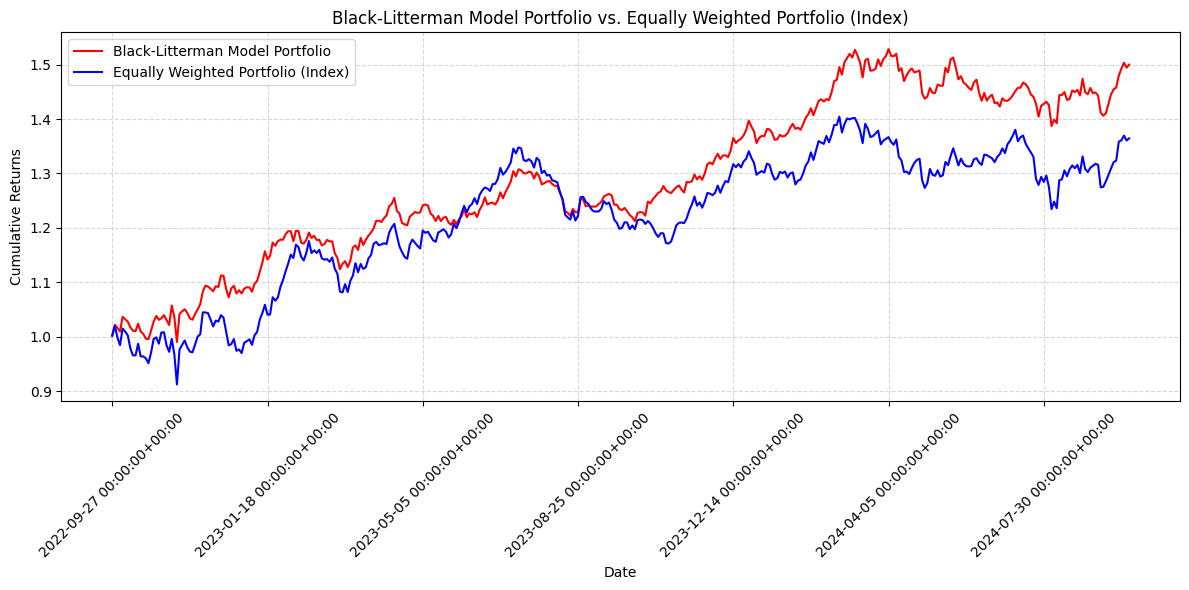

In [36]:
plt.figure(figsize=(12, 6))

# Plot the Mean-Downside Risk Portfolio cumulative returns
plt.plot(test_data.index, cumulative_returns_bl_test, label="Black-Litterman Model Portfolio", color="red")

# Plot the Equally Weighted Portfolio (Index) cumulative returns
plt.plot(test_data.index, cumulative_returns_eqw_test, label="Equally Weighted Portfolio (Index)", color="blue")
plt.xticks(test_data.index[::60], rotation=45)
# Customize the plot
plt.title("Black-Litterman Model Portfolio vs. Equally Weighted Portfolio (Index)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
# Convert the optimized portfolio weights for the Black-Litterman Model to percentages and round to 2 decimal places
optimal_weights_bl_percent = (optimal_weights_bl * 100).round(1)

# Create a DataFrame to display the weights clearly
weights_df = pd.DataFrame({
    "Asset": train_data.columns,
    "Weight (%)": optimal_weights_bl_percent
})

weights_df.set_index("Asset", inplace=True)

# Display the table with the weights
weights_df

,Weight (%)
Asset,
AAPL,0.0
BTC-USD,11.3
CL=F,10.2
ETH-USD,9.1
GC=F,45.0
JPM,12.0
MSFT,9.2
QQQ,0.0
TSLA,1.2


### Minimum Tail Dependence Portfolio



```
The Minimum Tail Dependence Portfolio aims to minimize the likelihood of extreme losses occurring simultaneously across assets. Tail dependence focuses on the correlation structure in the tails of the distribution, making it particularly relevant for managing systemic risk during market downturns.

Implementation Logic:
1. Model Tail Dependence: Use statistical methods to estimate the tail dependence structure between assets, such as copulas.
2. Objective: Construct a portfolio that minimizes the overall tail dependence risk, using an optimization framework.
3. Performance Metrics: As before, we will calculate annualized return, volatility, Sharpe ratio, and maximum drawdown.
```



In [38]:
# Calculate Tail Dependence using Kendall's Tau
def tail_dependence_matrix(returns):
    num_assets = returns.shape[1]
    tail_dependence = np.zeros((num_assets, num_assets))

    # Compute Kendall's Tau for each pair of assets
    for i in range(num_assets):
        for j in range(num_assets):
            if i != j:
                tau, _ = kendalltau(returns[:, i], returns[:, j])
                tail_dependence[i, j] = abs(tau)  # Take the absolute value of Kendall's Tau
    return tail_dependence

# Compute the tail dependence matrix using the training data
tail_dependence = tail_dependence_matrix(train_data.values)

# Define the objective function to minimize tail dependence
def objective_function(weights, tail_dependence):
    # Portfolio tail dependence is a weighted sum of tail dependence coefficients
    portfolio_tail_risk = np.dot(weights.T, np.dot(tail_dependence, weights))
    return portfolio_tail_risk

# Set up the optimization problem
num_assets = train_data.shape[1]
initial_weights = np.ones(num_assets) / num_assets  # Start with equal weights
bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]  # Sum of weights equals 1

# Optimize the portfolio to minimize tail dependence using the training data
result = minimize(objective_function, initial_weights,
                  args=(tail_dependence,),
                  bounds=bounds, constraints=constraints)

# Extract the optimized weights
optimal_weights_mtd = result.x
print("Optimized Portfolio Weights (Minimum Tail Dependence):", optimal_weights_mtd)

# Evaluate the portfolio on the test data
# Portfolio returns on the test data
portfolio_returns_mtd_test = np.dot(test_data.values, optimal_weights_mtd)
average_daily_return_mtd_test = np.mean(portfolio_returns_mtd_test)
daily_volatility_mtd_test = np.std(portfolio_returns_mtd_test)

# Annualize metrics
trading_days_per_year = 252
annualized_return_mtd_test = (1 + average_daily_return_mtd_test) ** trading_days_per_year - 1
annualized_volatility_mtd_test = daily_volatility_mtd_test * np.sqrt(trading_days_per_year)

# Sharpe Ratio
risk_free_rate = 0  # Adjust if needed
sharpe_ratio_mtd_test = (annualized_return_mtd_test - risk_free_rate) / annualized_volatility_mtd_test

# Calculate drawdown
cumulative_returns_mtd_test = np.cumprod(1 + portfolio_returns_mtd_test)
peak_mtd_test = np.maximum.accumulate(cumulative_returns_mtd_test)
drawdown_mtd_test = (cumulative_returns_mtd_test - peak_mtd_test) / peak_mtd_test
max_drawdown_mtd_test = np.min(drawdown_mtd_test)

# Print the metrics
print("Annualized Return (Test Data):", round(annualized_return_mtd_test, 2))
print("Annualized Volatility (Test Data):", round(annualized_volatility_mtd_test, 2))
print("Sharpe Ratio (Test Data):", round(sharpe_ratio_mtd_test, 2))
print("Maximum Drawdown (Test Data):", round(max_drawdown_mtd_test, 2))

Optimized Portfolio Weights (Minimum Tail Dependence): [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.99948407e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.60662540e-15 5.15933963e-05]
Annualized Return (Test Data): 0.36
Annualized Volatility (Test Data): 0.14
Sharpe Ratio (Test Data): 2.52
Maximum Drawdown (Test Data): -0.1


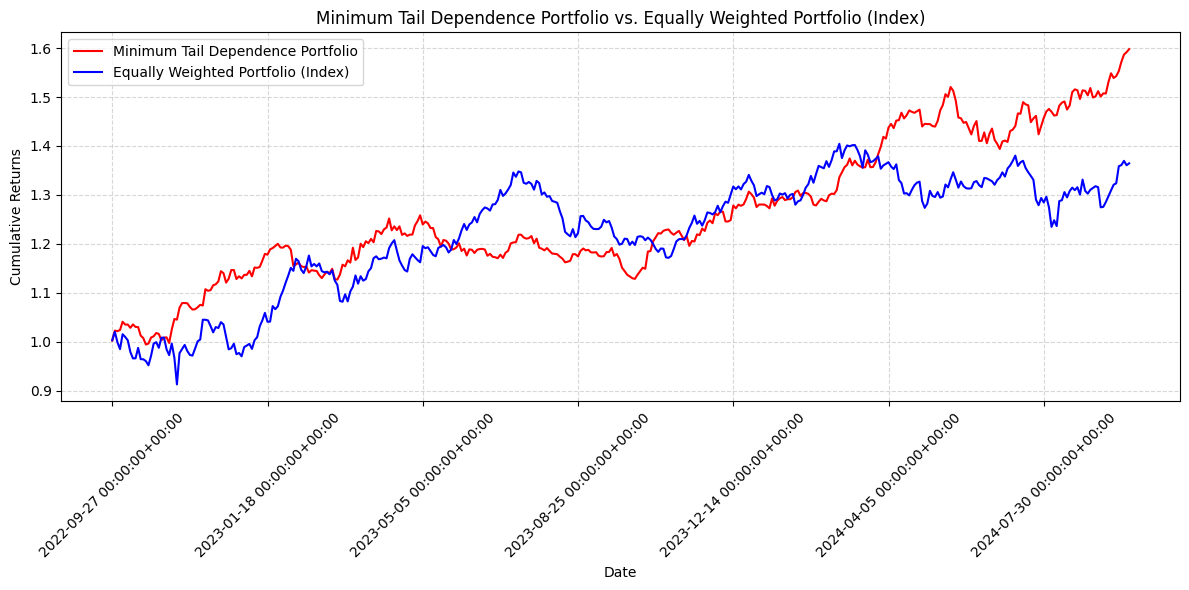

In [39]:
plt.figure(figsize=(12, 6))

# Plot the Mean-Downside Risk Portfolio cumulative returns
plt.plot(test_data.index, cumulative_returns_mtd_test, label="Minimum Tail Dependence Portfolio", color="red")

# Plot the Equally Weighted Portfolio (Index) cumulative returns
plt.plot(test_data.index, cumulative_returns_eqw_test, label="Equally Weighted Portfolio (Index)", color="blue")
plt.xticks(test_data.index[::60], rotation=45)
# Customize the plot
plt.title("Minimum Tail Dependence Portfolio vs. Equally Weighted Portfolio (Index)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [40]:
# Convert the optimized portfolio weights for the Black-Litterman Model to percentages and round to 2 decimal places
optimal_weights_mtd_percent = (optimal_weights_mtd * 100).round(1)

# Create a DataFrame to display the weights clearly
weights_df = pd.DataFrame({
    "Asset": train_data.columns,
    "Weight (%)": optimal_weights_mtd_percent
})

weights_df.set_index("Asset", inplace=True)

# Display the table with the weights
weights_df

,Weight (%)
Asset,
AAPL,0.0
BTC-USD,0.0
CL=F,0.0
ETH-USD,0.0
GC=F,100.0
JPM,0.0
MSFT,0.0
QQQ,0.0
TSLA,0.0


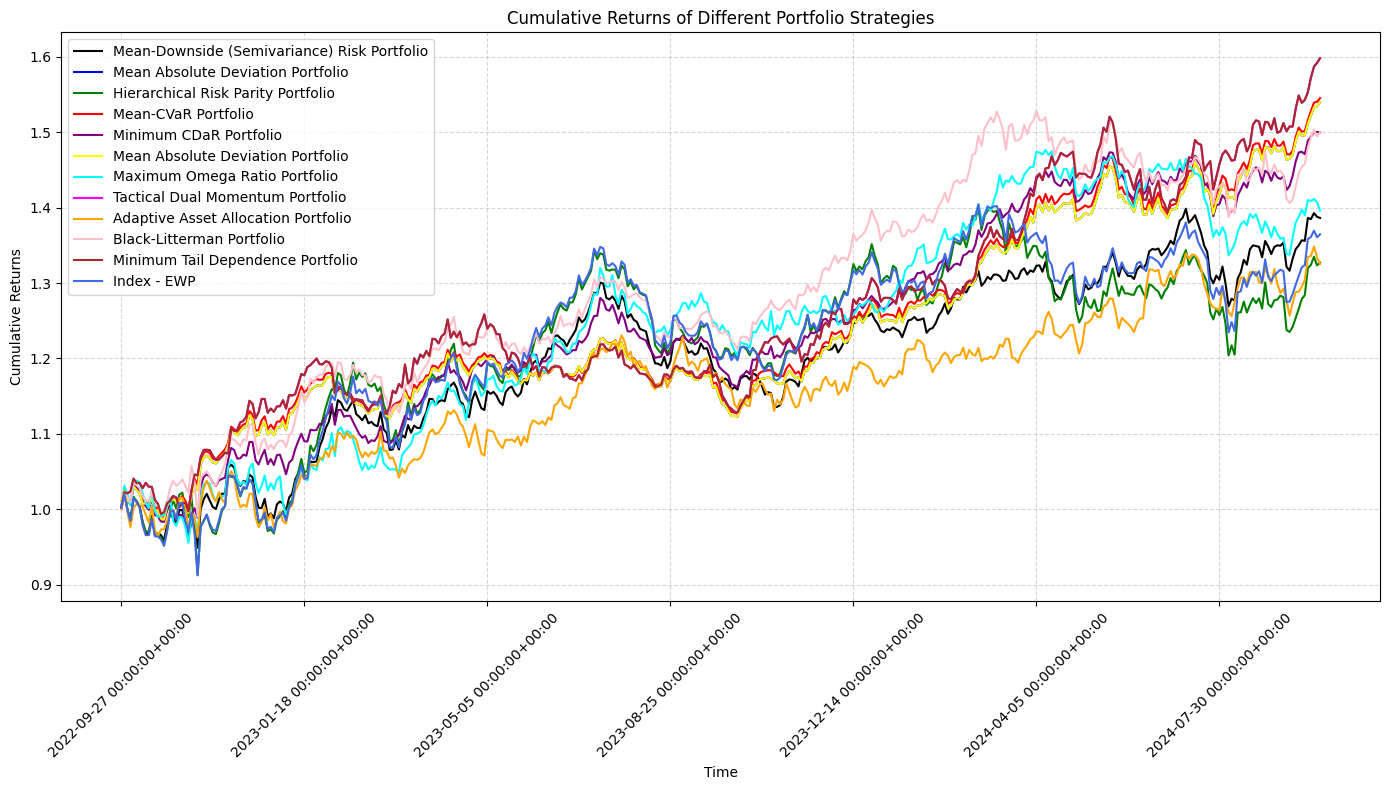

In [41]:
# Compute cumulative returns for each portfolio
cumulative_returns_mds_test = np.cumprod(1 + portfolio_returns_mds_test)  # Mean-downside (Semivariance ) risk portfolio
cumulative_returns_mdr_test = np.cumprod(1 + portfolio_returns_mad_test)  # Mean Absolute Deviation Portfolio
cumulative_returns_hrp_test = np.cumprod(1 + portfolio_returns_hrp_test)  # Hierarchical Risk Parity Portfolio
cumulative_returns_mcv_test = np.cumprod(1 + portfolio_returns_cvar_test)  # Mean-CVaR Portfolio
cumulative_returns_cdar_test = np.cumprod(1 + portfolio_returns_cdar_test)  # Minimum CDaR Portfolio
cumulative_returns_mad_test = np.cumprod(1 + portfolio_returns_mad_test)  # Mean Absolute Deviation Portfolio
cumulative_returns_mor_test = np.cumprod(1 + portfolio_returns_mor_test)  # Maximum Omega Ratio Portfolio
cumulative_returns_tdm_test = np.cumprod(1 + portfolio_returns_tdm_test)  # Tactical Dual Momentum Portfolio
cumulative_returns_aaa_test = np.cumprod(1 + portfolio_returns_aaa_test)  # Adaptive Asset Allocation Portfolio
cumulative_returns_bl_test = np.cumprod(1 + portfolio_returns_bl_test)  # Black-Litterman Portfolio
cumulative_returns_mtd_test = np.cumprod(1 + portfolio_returns_mtd_test)  # Minimum Tail Dependence Portfolio
cumulative_returns_eqw_test = np.cumprod(1 + portfolio_returns_eqw_test)  # Index - EWP

# Plot cumulative returns for all portfolios
plt.figure(figsize=(14, 8))

plt.plot(test_data.index, cumulative_returns_mds_test, color="black", label="Mean-Downside (Semivariance) Risk Portfolio")
plt.plot(test_data.index, cumulative_returns_mad_test, color="blue", label="Mean Absolute Deviation Portfolio")
plt.plot(test_data.index, cumulative_returns_hrp_test, color="green", label="Hierarchical Risk Parity Portfolio")
plt.plot(test_data.index, cumulative_returns_mcv_test, color="red", label="Mean-CVaR Portfolio")
plt.plot(test_data.index, cumulative_returns_cdar_test, color="purple", label="Minimum CDaR Portfolio")
plt.plot(test_data.index, cumulative_returns_mad_test, color="yellow", label="Mean Absolute Deviation Portfolio")
plt.plot(test_data.index, cumulative_returns_mor_test, color="cyan", label="Maximum Omega Ratio Portfolio")
plt.plot(test_data.index, cumulative_returns_tdm_test, color="magenta", label="Tactical Dual Momentum Portfolio")
plt.plot(test_data.index, cumulative_returns_aaa_test, color="orange", label="Adaptive Asset Allocation Portfolio")
plt.plot(test_data.index, cumulative_returns_bl_test, color="pink", label="Black-Litterman Portfolio")
plt.plot(test_data.index, cumulative_returns_mtd_test, color="brown", label="Minimum Tail Dependence Portfolio")
plt.plot(test_data.index, cumulative_returns_eqw_test, color="#4169E1", label="Index - EWP")

plt.xticks(test_data.index[::60], rotation=45)

# Customize the plot
plt.title("Cumulative Returns of Different Portfolio Strategies")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend(loc="upper left")
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Step 4: Display the plot
plt.show()

In [46]:
# Create a dictionary with performance metrics for each portfolio
# (Assuming you have already calculated these metrics for each portfolio in the test set)
performance_data = {
    "Portfolio": [
        "Mean-Downside (Semivariance) Risk Portfolio",
        "Mean Absolute Deviation Portfolio",
        "Hierarchical Risk Parity Portfolio",
        "Mean-CVaR Portfolio",
        "Minimum CDaR Portfolio",
        "Maximum Omega Ratio Portfolio",
        "Tactical Dual Momentum Portfolio",
        "Adaptive Asset Allocation Portfolio",
        "Black-Litterman Portfolio",
        "Minimum Tail Dependence Portfolio",
        "Index"
    ],
    "Annualized Return": [
        annualized_return_mds_test,
        annualized_return_mad_test,
        annualized_return_hrp_test,
        annualized_return_cvar_test,
        annualized_return_cdar_test,
        annualized_return_mor_test,
        annualized_return_tdm_test,
        annualized_return_aaa_test,
        annualized_return_bl_test,
        annualized_return_mtd_test,
        annualized_return_eqw_test
    ],
    "Annualized Volatility": [
        annualized_volatility_mds_test,
        annualized_volatility_mad_test,
        annualized_volatility_hrp_test,
        annualized_volatility_cvar_test,
        annualized_volatility_cdar_test,
        annualized_volatility_mor_test,
        annualized_volatility_tdm_test,
        annualized_volatility_aaa_test,
        annualized_volatility_bl_test,
        annualized_volatility_mtd_test,
        annualized_volatility_eqw_test
    ],
    "Sharpe Ratio": [
        sharpe_ratio_mds_test,
        sharpe_ratio_mad_test,
        sharpe_ratio_hrp_test,
        sharpe_ratio_cvar_test,
        sharpe_ratio_cdar_test,
        sharpe_ratio_mor_test,
        sharpe_ratio_tdm_test,
        sharpe_ratio_aaa_test,
        sharpe_ratio_bl_test,
        sharpe_ratio_mtd_test,
        sharpe_ratio_eqw_test
    ],
    "Maximum Drawdown": [
        max_drawdown_mds_test,
        max_drawdown_mad_test,
        max_drawdown_hrp_test,
        max_drawdown_cvar_test,
        max_drawdown_cdar_test,
        max_drawdown_mor_test,
        max_drawdown_tdm_test,
        max_drawdown_aaa_test,
        max_drawdown_bl_test,
        max_drawdown_mtd_test,
        max_drawdown_eqw_test
    ]
}

# Create a DataFrame from the dictionary
performance_table = pd.DataFrame(performance_data)

# Format the table to make it more presentable
performance_table.set_index("Portfolio", inplace=True)
performance_table = performance_table.round(4)  # Round numbers for better readability


# Display the table to the user
tools.display_dataframe_to_user("Portfolio Performance Metrics", performance_table)

Portfolio Performance Metrics
